First figure of the manuscript, introductory. 
- examples of raw traces (both LFP and gamma) during wake and sleep.
- associated ACF and PSD during sleep stages
- accompanying fits on the functions.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.io import loadmat
import pickle
import matplotlib.pyplot as plt
from nilearn import surface as nisurf
import plotly.graph_objects as go

import mni_utils as uti
from mni_plots import _set_font_params, _reset_default_rc

Paths and names:

In [3]:
data_path = Path("F:\\iEEG_neural_dynamics\\MNIOpen")
tau_path = data_path.joinpath("Results_acf_fit_exp")
exp_path = data_path.joinpath("Results_psd_exp")
fig_path = data_path.joinpath("Figures")

Get data and info:

In [4]:
data = loadmat(data_path.joinpath("MatlabFile.mat"))
data_W = data["Data_W"].T
data_N2 = data["Data_N2"].T
data_N3 = data["Data_N3"].T
data_R = data["Data_R"].T

# Export info as a dataframe
ch_names = data["ChannelName"].squeeze()
ch_types = data["ChannelType"].squeeze()
ch_regs = data["ChannelRegion"].squeeze()
pat_ids = data["Patient"].squeeze()
gender = data["Gender"].squeeze()
age = data["AgeAtTimeOfStudy"].squeeze()
ch_pos = data["ChannelPosition"].squeeze()
regions_map = {i + 1: r[0][0] for i, r in enumerate(data["RegionName"])}
sfreq = data["SamplingFrequency"][0][0]
df_info = pd.DataFrame(
    {
        "pat": pat_ids,
        "chan": [ch[0] for ch in ch_names],
        "type": [t[0] for t in ch_types],
        "region": ch_regs,
        "mni_x": ch_pos[:, 0],
        "mni_y": ch_pos[:, 1],
        "mni_z": ch_pos[:, 2],
    }
)

Selected patients and channels to plot:

In [11]:
# Patients and channels to use
pats = [103, 106, 53]
chans = ["NG103LG117", "NG106LP14", "MD053RA1"]
lobes = ["Frontal", "Parietal", "Temporal"]

# Times for traces plot
t_start = 2
t_end = t_start + 1

Define names and colors:

In [6]:
stages_dict = {"W": "Wake", "N3": "NREM3", "R": "REM"}
color_stages = {"W": "red", "N3": "purple", "R": "green"}

### A) Plot overview of all channels in the dataset:

In [8]:
# Load surface
surface = nisurf.load_surf_mesh(data_path.joinpath("surfaces", "cortex_5124.surf.gii"))

_set_font_params()
# First, create surface plot
surf_trace = go.Mesh3d(
    x=surface.coordinates[:, 0],
    y=surface.coordinates[:, 1],
    z=surface.coordinates[:, 2],
    i=surface.faces[:, 0],
    j=surface.faces[:, 1],
    k=surface.faces[:, 2],
    color="gainsboro",
    opacity=0.9,
    hoverinfo="skip",
    showscale=False,
)

# Then, the scatterplot
scatter_trace = go.Scatter3d(
    x=df_info["mni_x"],
    y=df_info["mni_y"],
    z=df_info["mni_z"],
    mode="markers",
    marker=dict(
        size=4,
        color="black",
        opacity=0.8,
    ),
    hoverinfo="skip",
)

#  Highlight selected channels
mni_coords = df_info.loc[df_info["chan"].isin(chans), ["mni_x", "mni_y", "mni_z"]].to_numpy()
ch_traces = go.Scatter3d(
    x=mni_coords[:, 0],
    y=mni_coords[:, 1],
    z=mni_coords[:, 2],
    mode="markers",
    marker=dict(
        size=10,
        color="green",
        opacity=0.99,
    ),
    hoverinfo="skip",
)

# Put together the two plots
fig = go.Figure(
    data=[surf_trace, scatter_trace, ch_traces],
)

# Update the layout
fig.update_layout(
    {
        "paper_bgcolor": "rgba(0,0,0,0)",  # transparent, to make it dark set a=0.8
    },
    scene=dict(
        xaxis=dict(
            backgroundcolor="rgba(0,0,0,0)",
            gridcolor="rgba(0,0,0,0.0)",
            color="white",
            zeroline=False,
            showticklabels=False,
            title_text="",
        ),
        yaxis=dict(
            backgroundcolor="rgba(0,0,0,0)",
            gridcolor="rgba(0,0,0,0.0)",
            color="white",
            zeroline=False,
            showticklabels=False,
            title_text="",
        ),
        zaxis=dict(
            backgroundcolor="rgba(0,0,0,0)",
            gridcolor="rgba(0,0,0,0.0)",
            color="white",
            zeroline=False,
            showticklabels=False,
            title_text="",
        ),
    ),
    margin=dict(l=0, r=0, b=0, t=0),
    scene_camera=dict(eye=dict(x=0, y=1.5, z=0)),
    showlegend=False,
)
# Frontal view
fig.write_image(fig_path.joinpath("Fig_0", f"Contacts_overview_front.svg"))

# Top view
fig.update_layout(
    scene_camera=dict(eye=dict(x=0, y=0, z=1.5)),
)
fig.write_image(fig_path.joinpath("Fig_0", f"Contacts_overview_top.svg"))

_reset_default_rc()

### B) Plot examples of traces:

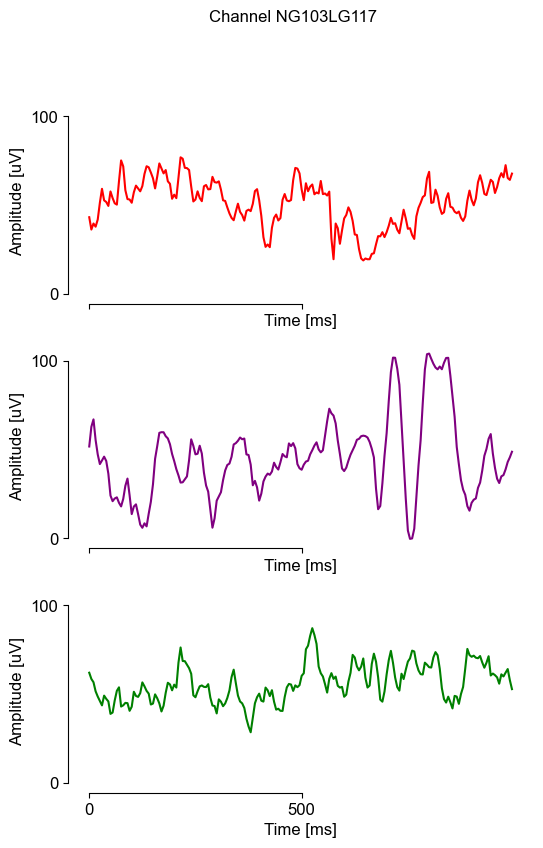

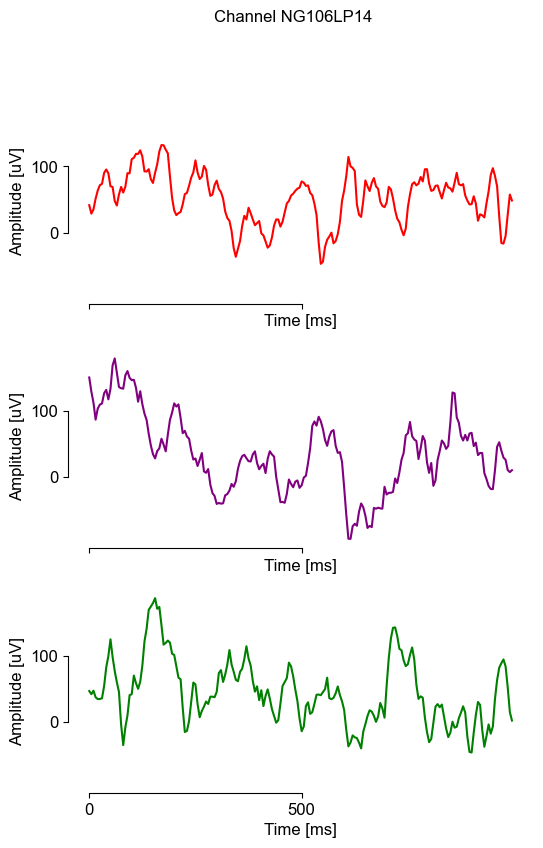

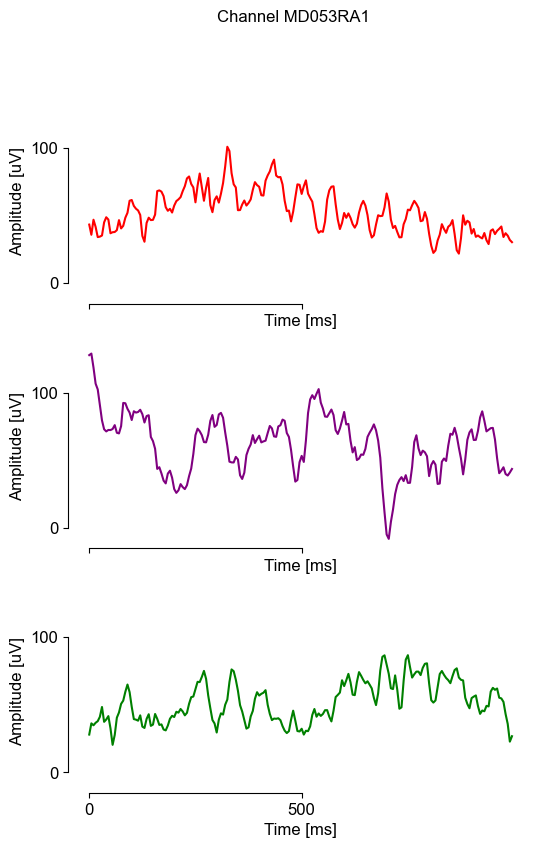

In [9]:
_set_font_params()
# Plot traces
idx_start = int(t_start * sfreq)
idx_end = int(t_end * sfreq)
for ch in chans:
    fig, axs = plt.subplots(3, 1, figsize=(6, 9), sharex=True, sharey=True)
    idx = df_info.loc[df_info["chan"] == ch].index[0]
    axs[0].plot(data_W[idx, idx_start:idx_end], c=color_stages["W"], label="Wake")
    axs[1].plot(data_N3[idx, idx_start:idx_end], c=color_stages["N3"], label="NREM3")
    axs[2].plot(data_R[idx, idx_start:idx_end], c=color_stages["R"], label="REM")
    for i in range(3):
        axs[i].spines[["top", "right"]].set_visible(False)
        axs[i].set_xticks([0, int(sfreq / 2)], labels=[0, 500], fontsize=12)
        axs[i].spines["bottom"].set_bounds(0, int(sfreq / 2))
        axs[i].set_xlabel("Time [ms]", fontsize=12)
        axs[i].set_yticks([-50, 50], labels=[0, 100], fontsize=12)
        axs[i].spines["left"].set_bounds(-50, 50)
        axs[i].set_ylabel("Amplitude [uV]", fontsize=12)
    fig.suptitle(f"Channel {ch}")
    fig.savefig(fig_path.joinpath("Fig_0", f"traces_{ch}.svg"), format="svg")
    plt.show()
_reset_default_rc()

Plot same examples, but filtered in the gamma band:

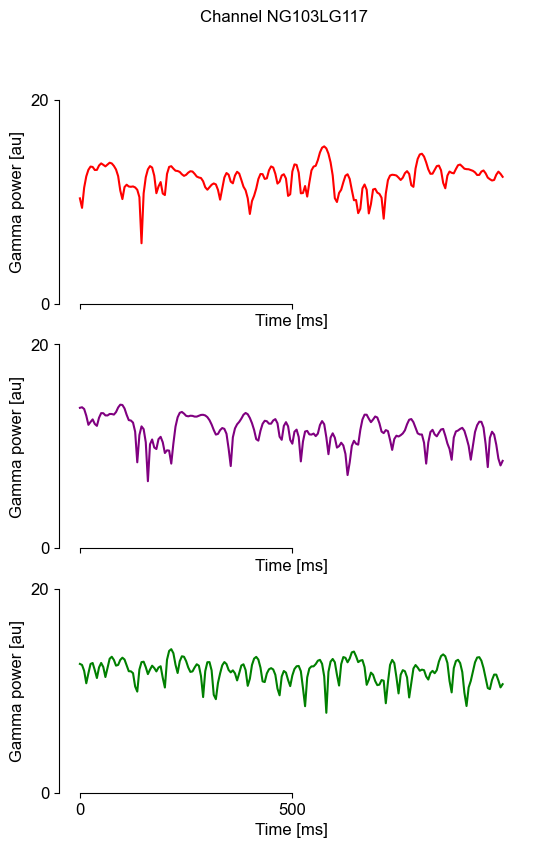

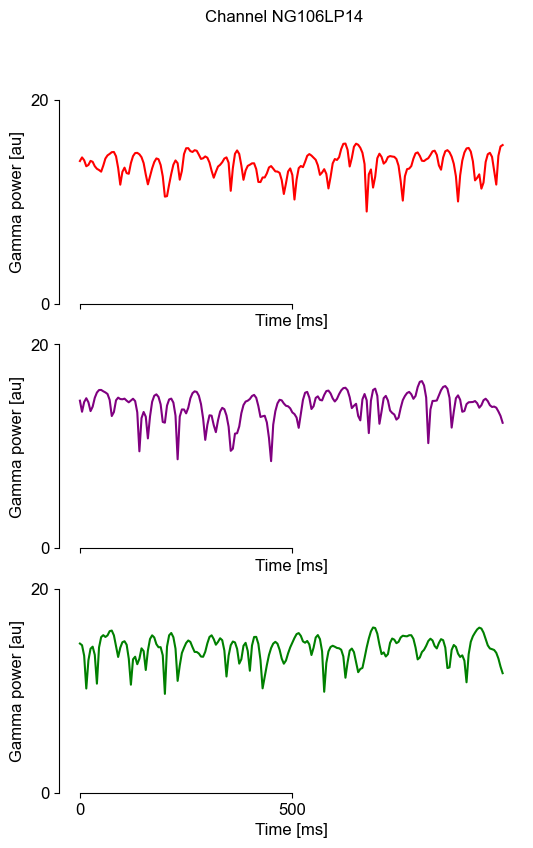

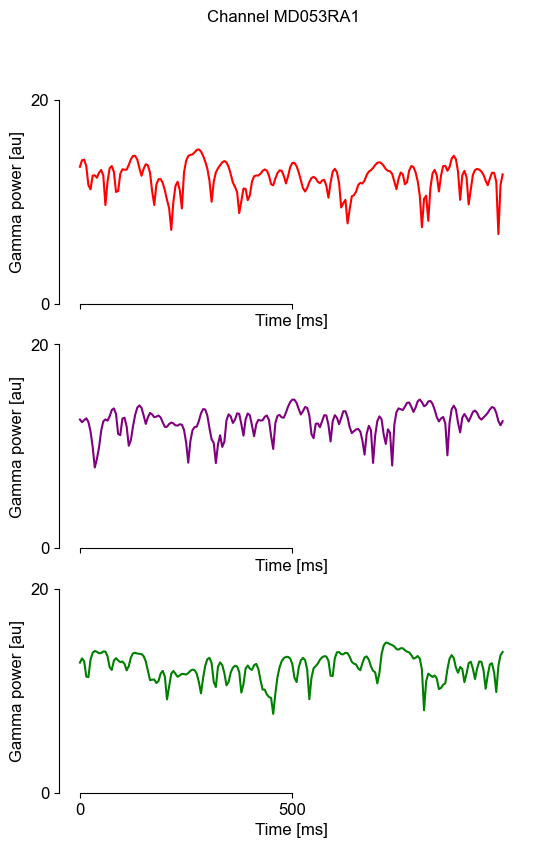

In [13]:
_set_font_params()

# Plot traces
idx_start = int(t_start * sfreq)
idx_end = int(t_end * sfreq)
for pat, ch in zip(pats, chans):
    fig, axs = plt.subplots(3, 1, figsize=(6, 9), sharex=True, sharey=True)
    # Create raw data
    for i, (stage, dat_stage) in enumerate(
        zip(["W", "N3", "R"], [data_W, data_N3, data_R])
    ):
        # Select data for patient and stage
        idx_pat = df_info.loc[df_info["pat"] == pat].index
        data_stage_pat = dat_stage[idx_pat]
        chans_stage_pat = df_info.loc[idx_pat, "chan"].to_list()
        # Create raw
        raw_stage_pat = uti.create_RawMNE(data_stage_pat, chans_stage_pat, sfreq)
        # Filter and get gamma
        raw_stage_pat.filter(40, 80, verbose=False)
        raw_stage_pat.apply_hilbert(envelope=True)
        # Apply log-transformation to make data more "normal"
        raw_stage_pat._data = np.log(raw_stage_pat._data**2)
        # Pick channel and time
        data_chan = raw_stage_pat.get_data(picks=ch, tmin=t_start, tmax=t_end)

        # Plot
        axs[i].plot(data_chan[0], c=color_stages[stage], label=stages_dict[stage])
        axs[i].spines[["top", "right"]].set_visible(False)
        axs[i].set_xticks([0, int(sfreq / 2)], labels=[0, 500], fontsize=12)
        axs[i].spines["bottom"].set_bounds(0, int(sfreq / 2))
        axs[i].set_xlabel("Time [ms]", fontsize=12)
        axs[i].set_yticks([-10, 10], labels=[0, 20], fontsize=12)
        axs[i].spines["left"].set_bounds(-10, 10)
        axs[i].set_ylabel("Gamma power [au]", fontsize=12)
    fig.suptitle(f"Channel {ch}")
    fig.savefig(fig_path.joinpath("Fig_0", f"traces_{ch}_gamma.svg"), format="svg")
    plt.show()

_reset_default_rc()

Plot ACFs from the 4 lobes:

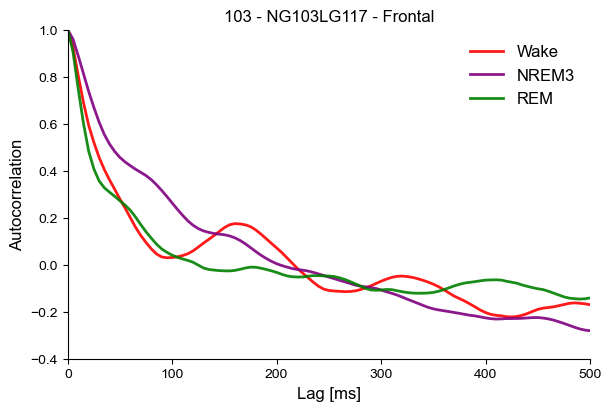

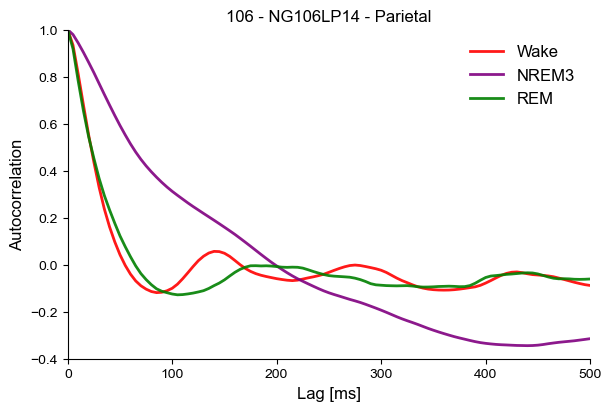

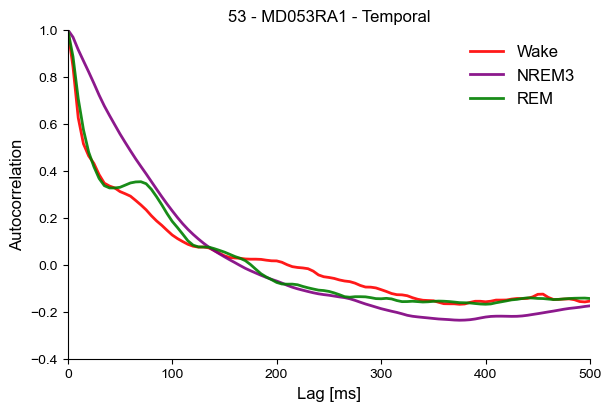

In [12]:
_set_font_params()

for pat, chan, lobe in zip(pats, chans, lobes):
    pat_dir = tau_path.joinpath(str(pat).zfill(3))
    fig, ax = plt.subplots(figsize=(6, 4), layout="constrained")

    for stage in ["W", "N3", "R"]:
        # Load ACF
        with open(
            pat_dir.joinpath("ACF/" + str(pat).zfill(3) + "_" + stage.lower() + ".pkl"),
            "rb",
        ) as f:
            acf_pat_stage = pickle.load(f)
        idx_chan = acf_pat_stage["chans"].index(chan)

        # Figure ACF
        ax.plot(
            acf_pat_stage["lags"] * 1000,
            acf_pat_stage["acf"][:, idx_chan].mean(axis=0),
            c=color_stages[stage],
            label=stages_dict[stage],
            lw=2,
            alpha=0.9,
        )
        title = " - ".join([str(pat), chan, lobe])
        ax.set_title(title)
        ax.set_xlim(0, 500)
        ax.set_ylim(-0.4, 1)
        ax.set_xlabel("Lag [ms]", fontsize=12)
        ax.set_ylabel("Autocorrelation", fontsize=12)
        ax.spines[["top", "right"]].set_visible(False)
    ax.legend(frameon=False, fontsize=12)
    fig.savefig(fig_path.joinpath("Fig_0", f"ACF_{pat}_{chan}.svg"), format="svg")

    plt.show()

_reset_default_rc()

Plot PSDs from the 4 lobes:

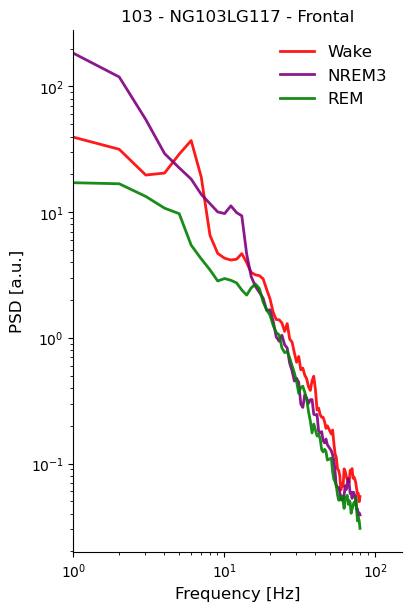

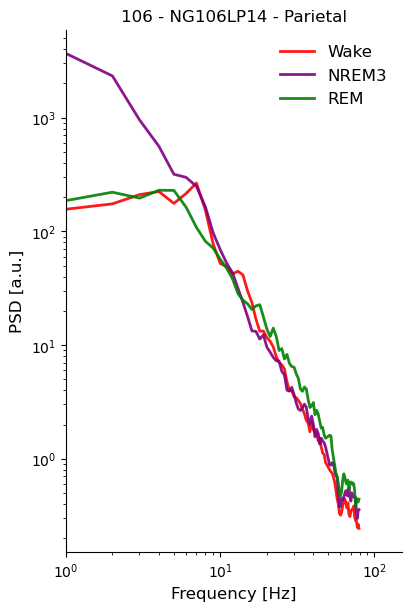

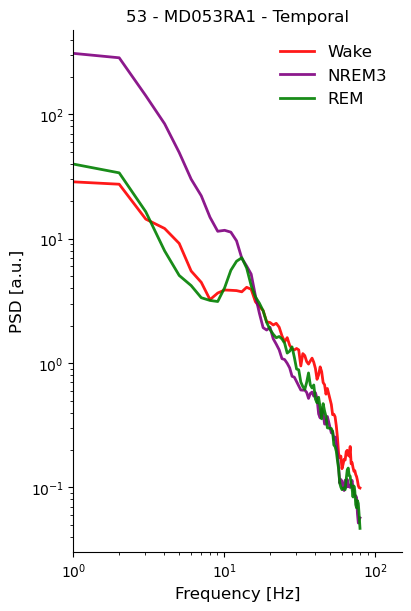

In [62]:
# Patients and channels to use
pats = [103, 106, 53]
chans = ["NG103LG117", "NG106LP14", "MD053RA1"]
lobes = ["Frontal", "Parietal", "Temporal"]

stages_dict = {"W": "Wake", "N3": "NREM3", "R": "REM"}
color_stages = {"W": "red", "N3": "purple", "R": "green"}

for pat, chan, lobe in zip(pats, chans, lobes):
    pat_dir = exp_path.joinpath(str(pat).zfill(3))
    fig, ax = plt.subplots(figsize=(4, 6), layout="constrained")

    for stage in ["W", "N3", "R"]:
        # Load PSD
        with open(
            pat_dir.joinpath("PSD/" + str(pat).zfill(3) + "_" + stage.lower() + ".pkl"),
            "rb",
        ) as f:
            psd_pat_stage = pickle.load(f)
        idx_chan = psd_pat_stage["chans"].index(chan)

        # Figure ACF
        ax.plot(
            psd_pat_stage["freqs"],
            psd_pat_stage["psd"][:, idx_chan].mean(axis=0),
            c=color_stages[stage],
            label=stages_dict[stage],
            lw=2,
            alpha=0.9,
        )
        title = " - ".join([str(pat), chan, lobe])
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_title(title)
        ax.set_xlim(1, 150)
        # ax.set_ylim(-0.4, 1)
        ax.set_xlabel("Frequency [Hz]", fontsize=12)
        ax.set_ylabel("PSD [a.u.]", fontsize=12)
        ax.spines[["top", "right"]].set_visible(False)
    ax.legend(frameon=False, fontsize=12)
    fig.savefig(fig_path.joinpath("Fig_0", f"PSD_{pat}_{chan}.svg"), format="svg")

    plt.show()